# Sommaire

- [1. Exploration préliminaire (données brutes)](#section-01-prelim)
- [2. Nettoyage & préparation des données](#section-02-cleaning)
- [3. Exploration des données (après nettoyage)](#section-03-exploration)
- [4. Feature Engineering](#section-04-feature-engineering)
- [5. Feature Engineering – Prophet](#section-05-feature-engineering-prophet)
- [6. Modélisation](#section-06-modeling)
- [7. Analyse des résultats](#section-07-analysis)


<a id="section-01-prelim"></a>

# 01 — Exploration préliminaire (données brutes)

Objectif : comprendre rapidement la structure, la granularité et la qualité des fichiers **avant** tout traitement.


In [37]:
%pip install -r /home/onyxia/france-grid-stress-prediction/requirements.txt

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Fichiers demandés (données non traitées / intermédiaires)
CONS_RAW_PATH = Path("/home/onyxia/france-grid-stress-prediction/data/interim/consommation/consommation_2019_long.csv")
WEATHER_RAW_PATH = Path("/home/onyxia/france-grid-stress-prediction/data/raw/weather/weather_32_cities_2019.csv")

print("Consommation raw/interim:", CONS_RAW_PATH, "exists:", CONS_RAW_PATH.exists())
print("Météo raw:", WEATHER_RAW_PATH, "exists:", WEATHER_RAW_PATH.exists())


Note: you may need to restart the kernel to use updated packages.
Consommation raw/interim: /home/onyxia/france-grid-stress-prediction/data/interim/consommation/consommation_2019_long.csv exists: True
Météo raw: /home/onyxia/france-grid-stress-prediction/data/raw/weather/weather_32_cities_2019.csv exists: True


In [38]:
# Chargement "safe" (le notebook doit rester exécutable même si les chemins changent)
df_cons_raw = None
df_weather_raw = None

if CONS_RAW_PATH.exists():
    df_cons_raw = pd.read_csv(CONS_RAW_PATH)
    print("df_cons_raw shape:", df_cons_raw.shape)
    display(df_cons_raw.head())

if WEATHER_RAW_PATH.exists():
    df_weather_raw = pd.read_csv(WEATHER_RAW_PATH)
    print("df_weather_raw shape:", df_weather_raw.shape)
    display(df_weather_raw.head())


df_cons_raw shape: (17520, 6)


,datetime,date,year,statut,slot_index,load_mw
0,2019-01-01 00:00:00,2019-01-01,2019,Provisoires,0,53574
1,2019-01-01 00:30:00,2019-01-01,2019,Provisoires,1,52882
2,2019-01-01 01:00:00,2019-01-01,2019,Provisoires,2,53140
3,2019-01-01 01:30:00,2019-01-01,2019,Provisoires,3,52870
4,2019-01-01 02:00:00,2019-01-01,2019,Provisoires,4,53476


df_weather_raw shape: (280320, 7)


,date,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover,city
0,2019-01-01 00:00:00+00:00,6.36,6.120000,0.0,0.0,63.0,Paris
1,2019-01-01 01:00:00+00:00,6.66,4.829907,0.0,0.0,87.0,Paris
2,2019-01-01 02:00:00+00:00,6.46,4.024922,0.0,0.0,96.0,Paris
3,2019-01-01 03:00:00+00:00,6.31,5.623380,0.0,0.0,100.0,Paris
4,2019-01-01 04:00:00+00:00,6.71,7.928178,0.0,0.0,100.0,Paris


In [39]:
# Contrôles rapides (types, valeurs manquantes, duplication)
def quick_report(df, name):
    if df is None:
        print(f"[{name}] non chargé (fichier introuvable).")
        return
    print(f"\n--- {name} ---")
    display(df.info())
    display(df.describe(include='all'))
    display(df.isna().mean().sort_values(ascending=False).head(15))
    print("Duplicats (lignes):", df.duplicated().sum())

quick_report(df_cons_raw, "Consommation 2019 (long)")
quick_report(df_weather_raw, "Météo 32 villes (2019)")



--- Consommation 2019 (long) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    17520 non-null  object
 1   date        17520 non-null  object
 2   year        17520 non-null  int64 
 3   statut      17520 non-null  object
 4   slot_index  17520 non-null  int64 
 5   load_mw     17520 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 821.4+ KB


None

,datetime,date,year,statut,slot_index,load_mw
count,17520,17520,17520.0,17520,17520.000000,17520.000000
unique,17520,365,NaN,1,NaN,NaN
top,2019-01-01 00:00:00,2019-01-01,NaN,Provisoires,NaN,NaN
freq,1,48,NaN,17520,NaN,NaN
mean,NaN,NaN,2019.0,NaN,23.500000,53716.649030
std,NaN,NaN,0.0,NaN,13.853794,11555.650027
min,NaN,NaN,2019.0,NaN,0.000000,30777.000000
25%,NaN,NaN,2019.0,NaN,11.750000,45030.750000
50%,NaN,NaN,2019.0,NaN,23.500000,52144.000000
75%,NaN,NaN,2019.0,NaN,35.250000,61459.000000


datetime      0.0
date          0.0
year          0.0
statut        0.0
slot_index    0.0
load_mw       0.0
dtype: float64

Duplicats (lignes): 0

--- Météo 32 villes (2019) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280320 entries, 0 to 280319
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               280320 non-null  object 
 1   temperature_2m     280320 non-null  float64
 2   wind_speed_10m     280320 non-null  float64
 3   direct_radiation   280320 non-null  float64
 4   diffuse_radiation  280320 non-null  float64
 5   cloud_cover        280320 non-null  float64
 6   city               280320 non-null  object 
dtypes: float64(5), object(2)
memory usage: 15.0+ MB


None

,date,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover,city
count,280320,280320.000000,280320.000000,280320.000000,280320.000000,280320.000000,280320
unique,8760,NaN,NaN,NaN,NaN,NaN,32
top,2019-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,Paris
freq,32,NaN,NaN,NaN,NaN,NaN,8760
mean,NaN,13.052136,12.807939,99.881503,54.635745,56.794467,NaN
std,NaN,7.380206,7.717712,179.211120,75.575675,40.239133,NaN
min,NaN,-9.304501,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,7.613000,7.091177,0.000000,0.000000,12.000000,NaN
50%,NaN,12.461251,11.159999,0.000000,5.000000,66.000000,NaN
75%,NaN,17.915500,16.946787,120.000000,96.000000,98.000000,NaN


date                 0.0
temperature_2m       0.0
wind_speed_10m       0.0
direct_radiation     0.0
diffuse_radiation    0.0
cloud_cover          0.0
city                 0.0
dtype: float64

Duplicats (lignes): 0


In [40]:
# Vérification temporelle (si une colonne datetime existe)
def try_datetime_coverage(df, name):
    if df is None:
        return
    # Heuristique sur noms de colonnes fréquents
    dt_cols = [c for c in df.columns if c.lower() in ["datetime", "date", "time", "timestamp", "ds"]]
    if not dt_cols:
        print(f"[{name}] aucune colonne datetime évidente.")
        return
    col = dt_cols[0]
    tmp = df.copy()
    tmp[col] = pd.to_datetime(tmp[col], errors="coerce")
    print(f"[{name}] colonne datetime utilisée: {col}")
    print("Taux datetime non parsées:", tmp[col].isna().mean())
    print("Min:", tmp[col].min(), "Max:", tmp[col].max())
    if tmp[col].notna().any():
        # fréquence indicative
        diffs = tmp[col].sort_values().diff().value_counts().head(5)
        print("Top diffs:", diffs.to_dict())

try_datetime_coverage(df_cons_raw, "Consommation 2019 (long)")
try_datetime_coverage(df_weather_raw, "Météo 32 villes (2019)")


[Consommation 2019 (long)] colonne datetime utilisée: datetime
Taux datetime non parsées: 0.0
Min: 2019-01-01 00:00:00 Max: 2019-12-31 23:30:00
Top diffs: {Timedelta('0 days 00:30:00'): 17519}
[Météo 32 villes (2019)] colonne datetime utilisée: date
Taux datetime non parsées: 0.0
Min: 2019-01-01 00:00:00+00:00 Max: 2019-12-31 23:00:00+00:00
Top diffs: {Timedelta('0 days 00:00:00'): 271560, Timedelta('0 days 01:00:00'): 8759}


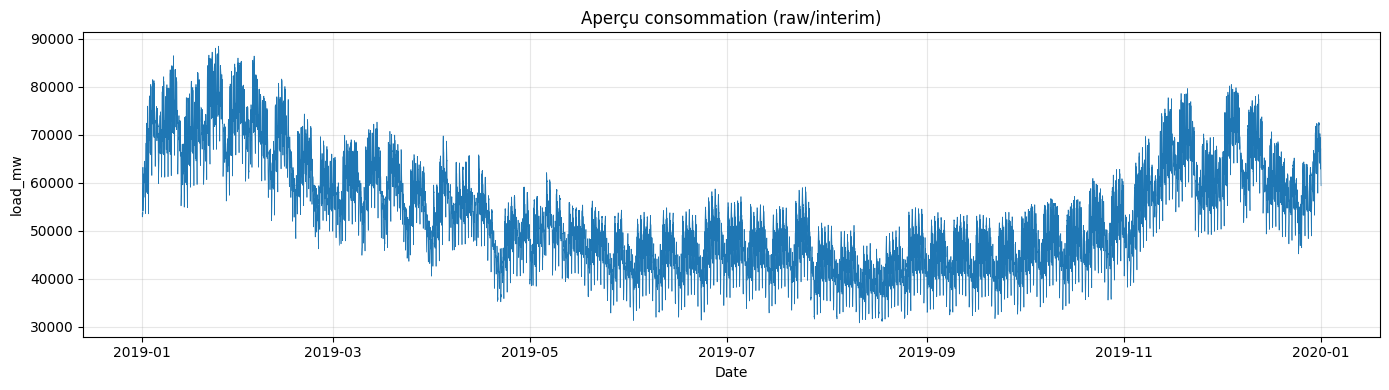

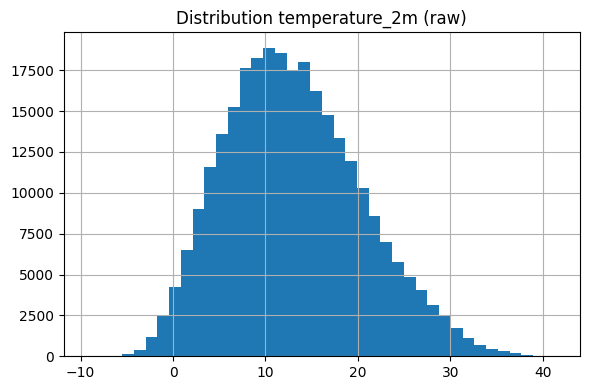

In [41]:
# Visualisations rapides (si possible)
if df_cons_raw is not None:
    # tentative: trouver une colonne de charge
    y_cols = [c for c in df_cons_raw.columns if any(k in c.lower() for k in ["load", "conso", "mw", "consumption"])]
    dt_cols = [c for c in df_cons_raw.columns if c.lower() in ["datetime", "date", "time", "timestamp", "ds"]]
    if dt_cols and y_cols:
        tmp = df_cons_raw[[dt_cols[0], y_cols[0]]].copy()
        tmp[dt_cols[0]] = pd.to_datetime(tmp[dt_cols[0]], errors="coerce")
        tmp = tmp.dropna().sort_values(dt_cols[0])
        plt.figure(figsize=(14,4))
        plt.plot(tmp[dt_cols[0]], tmp[y_cols[0]], linewidth=0.5)
        plt.title("Aperçu consommation (raw/interim)")
        plt.xlabel("Date")
        plt.ylabel(y_cols[0])
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

if df_weather_raw is not None:
    # apercu distribution température si identifiable
    temp_cols = [c for c in df_weather_raw.columns if "temp" in c.lower()]
    if temp_cols:
        plt.figure(figsize=(6,4))
        df_weather_raw[temp_cols[0]].dropna().hist(bins=40)
        plt.title(f"Distribution {temp_cols[0]} (raw)")
        plt.tight_layout()
        plt.show()


<a id="section-02-cleaning"></a>

# 2. Nettoyage des données

*Transition et contexte de la section suivante.*

# 02 — Nettoyage & préparation des données (consommation + météo)

Ce notebook prépare les **datasets propres** utilisés dans la suite du projet *Stress Grid* :

1. **Consommation nationale** : consolidation des fichiers `consommation_YYYY_long.csv` (pas 30 min) → `consommation_clean.parquet`
2. **Météo multi-villes** : nettoyage + contrôle de continuité horaire → agrégation nationale → `weather_national_hourly.parquet`
3. **Alignement temporel** : consommation (resample horaire) + météo nationale (horaire) → `dataset_model_hourly.parquet`

> Remarque : le “trou” 2020 (mai→septembre) est une **absence de données source** et n’est pas imputé dans le baseline.


## 0. Imports & configuration

Le code “lourd” est déporté dans `src/data/` afin de garder ce notebook lisible (orchestration + contrôles).


In [42]:
import os


if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /home/onyxia/france-grid-stress-prediction


In [43]:
import pandas as pd
import sys
from pathlib import Path



# On fixe le chemin "en dur"
PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")

# Ajoute la racine du projet en priorité (avant site-packages)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


DATA_DIR = PROJECT_ROOT / "data"
DATA_RAW = DATA_DIR / "interim"
DATA_PROCESSED = DATA_DIR / "processed"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_RAW exists:", DATA_RAW.exists())
print("DATA_PROCESSED exists:", DATA_PROCESSED.exists())





PROJECT_ROOT: /home/onyxia/france-grid-stress-prediction
DATA_RAW exists: True
DATA_PROCESSED exists: True


In [44]:
import sys
sys.path.append("/home/onyxia/work/france-grid-stress-prediction/src")

import pandas as pd
from pathlib import Path



import importlib, sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

print("Trying import src ...")
import src
print("src imported from:", src.__file__ if hasattr(src, "__file__") else src)

print("Trying import src.data ...")
import src.data
print("src.data imported from:", src.data.__file__ if hasattr(src.data, "__file__") else src.data)


Trying import src ...
src imported from: /home/onyxia/france-grid-stress-prediction/src/__init__.py
Trying import src.data ...
src.data imported from: /home/onyxia/france-grid-stress-prediction/src/data/__init__.py


## 1. Consommation électrique — nettoyage et consolidation

- Standardisation des colonnes (`datetime`, `load_mw`)
- Tri temporel + déduplication
- Contrôle simple de continuité (pas attendu = 30 min)
- Export en Parquet


In [45]:
from src.data.consumption_cleaning import ConsumptionCleanConfig, build_consumption_dataset


cfg_cons = ConsumptionCleanConfig(
    raw_dir=DATA_RAW / "consommation",   
    out_path=DATA_PROCESSED / "consommation_clean.parquet",
    pattern="consommation_*_long.csv",
)

df_cons, report_cons = build_consumption_dataset(cfg_cons)






### 1.1 Contrôles rapides

- Bornes temporelles
- Unicité de `datetime`
- Pas de temps observé (distribution des deltas)


In [46]:
df_cons["datetime"].min(), df_cons["datetime"].max(), len(df_cons), df_cons["datetime"].is_unique


(Timestamp('1996-01-01 00:00:00'),
 Timestamp('2025-09-30 23:30:00'),
 511248,
 True)

In [47]:
df_cons = df_cons.sort_values("datetime")
df_cons["datetime"].diff().value_counts().head(10)


datetime
0 days 00:30:00      511245
154 days 00:30:00         1
61 days 00:30:00          1
Name: count, dtype: int64

## 2. Météo — nettoyage, contrôle, agrégation nationale

- Nettoyage : colonnes, datetime (UTC → naïf), doublons (`city`, `datetime`)
- Contrôle de continuité horaire **par ville**
- Agrégation nationale : moyenne horaire sur l’ensemble des villes


In [48]:
from src.data.weather_cleaning import WeatherCleanConfig, build_weather_national_dataset
from pathlib import Path

raw_dir = Path("data/raw/weather")          # <-- adapte
out_path = Path("data/processed/weather_national_hourly.parquet")  

cfg_w = WeatherCleanConfig(raw_dir=raw_dir, out_path=out_path)

df_weather_nat, report_weather = build_weather_national_dataset(cfg_w)

display(report_weather.head(10))
df_weather_nat.head()





/home/onyxia/france-grid-stress-prediction/src/data/weather_cleaning.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  EXPECTED_FREQ = pd.Timedelta("1H")


,city,rows,min_dt,max_dt,n_bad_steps
0,Angers,254568,1996-01-01,2026-01-03 23:00:00,1
1,Avignon,254568,1996-01-01,2026-01-03 23:00:00,1
2,Bordeaux,254568,1996-01-01,2026-01-03 23:00:00,1
3,Brest,254568,1996-01-01,2026-01-03 23:00:00,1
4,Béthune,254568,1996-01-01,2026-01-03 23:00:00,1
5,Caen,254568,1996-01-01,2026-01-03 23:00:00,1
6,Clermont-Ferrand,254568,1996-01-01,2026-01-03 23:00:00,1
7,Dijon,254568,1996-01-01,2026-01-03 23:00:00,1
8,Douai - Lens,254568,1996-01-01,2026-01-03 23:00:00,1
9,Genève - Annemasse (partie française),254568,1996-01-01,2026-01-03 23:00:00,1


,datetime,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,1996-01-01 00:00:00,5.840688,7.772773,0.0,0.0,80.68750
1,1996-01-01 01:00:00,5.745375,7.550241,0.0,0.0,82.12500
2,1996-01-01 02:00:00,5.671937,7.425267,0.0,0.0,86.93750
3,1996-01-01 03:00:00,5.643812,7.596300,0.0,0.0,86.40625
4,1996-01-01 04:00:00,5.551625,7.971026,0.0,0.0,87.12500


In [49]:
w = pd.read_parquet(DATA_PROCESSED / "weather_national_hourly.parquet")
w["datetime"] = pd.to_datetime(w["datetime"])
print("weather years:", sorted(w["datetime"].dt.year.unique())[:5], "...", sorted(w["datetime"].dt.year.unique())[-5:])


weather years: [np.int32(1996), np.int32(1997), np.int32(1998), np.int32(1999), np.int32(2000)] ... [np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025), np.int32(2026)]


## 3. Alignement temporel et fusion (baseline)

- Consommation : resample horaire (moyenne)
- Fusion sur `datetime` (inner join)
- Contrôles : doublons, continuité horaire


In [50]:
from src.data.merge_datasets import MergeConfig, build_hourly_dataset

cfg_merge = MergeConfig(
    consumption_path=DATA_PROCESSED / "consommation_clean.parquet",
    weather_path=DATA_PROCESSED / "weather_national_hourly.parquet",
    out_path=DATA_PROCESSED / "dataset_model_hourly.parquet",
)

df_model = build_hourly_dataset(cfg_merge)
df_model.head()


/home/onyxia/france-grid-stress-prediction/src/data/merge_datasets.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H")


,datetime,load_mw,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,1996-01-01 00:00:00,40019.0,5.840688,7.772773,0.0,0.0,80.68750
1,1996-01-01 01:00:00,38747.5,5.745375,7.550241,0.0,0.0,82.12500
2,1996-01-01 02:00:00,37585.0,5.671937,7.425267,0.0,0.0,86.93750
3,1996-01-01 03:00:00,37354.5,5.643812,7.596300,0.0,0.0,86.40625
4,1996-01-01 04:00:00,37218.5,5.551625,7.971026,0.0,0.0,87.12500


In [51]:
# Contrôles de base
df_model["datetime"].duplicated().sum(), df_model["datetime"].diff().value_counts().head(5)


(np.int64(0),
 datetime
 0 days 01:00:00    254231
 Name: count, dtype: int64)

## 4. Focus : diagnostic du “trou” 2020 (consommation)

Objectif : vérifier que la discontinuité en 2020 provient bien des **fichiers source**.

- On filtre 2020 dans le dataset propre
- On compare la distribution mensuelle avec le fichier brut 2020


In [52]:
df_cons_2020 = df_cons[df_cons["datetime"].dt.year == 2020].copy()
df_cons_2020["month"] = df_cons_2020["datetime"].dt.month
df_cons_2020.groupby("month").size()


month
1     1488
2     1392
3     1488
4     1440
10    1440
dtype: int64

In [53]:
raw_2020_path = DATA_RAW / "consommation" / "consommation_2020_long.csv"
df_raw_2020 = pd.read_csv(raw_2020_path)
pd.to_datetime(df_raw_2020["datetime"]).dt.month.value_counts().sort_index()


datetime
1     1488
2     1392
3     1488
4     1440
10    1440
Name: count, dtype: int64

## (Optionnel) Reconstruction contrefactuelle des valeurs manquantes (Prophet)

Cette section produit une **version alternative** du dataset horaire dans laquelle les périodes manquantes
de consommation sont **remplies par un modèle Prophet** entraîné sur les observations disponibles.

**Important :** cette étape est réalisée **uniquement à des fins de comparaison méthodologique**
(baseline sans interpolation vs baseline avec comblement). Elle ne constitue pas une méthode d’imputation
retenue pour un usage opérationnel.


In [54]:
PATH = "/home/onyxia/france-grid-stress-prediction/data/processed/dataset_model_hourly.parquet"
df = pd.read_parquet(PATH)

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254232 entries, 0 to 254231
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datetime           254232 non-null  datetime64[ns]
 1   load_mw            249072 non-null  float64       
 2   temperature_2m     254232 non-null  float64       
 3   wind_speed_10m     254232 non-null  float64       
 4   direct_radiation   254232 non-null  float64       
 5   diffuse_radiation  254232 non-null  float64       
 6   cloud_cover        254232 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.6 MB


,datetime,load_mw,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,1996-01-01 00:00:00,40019.0,5.840688,7.772773,0.0,0.0,80.68750
1,1996-01-01 01:00:00,38747.5,5.745375,7.550241,0.0,0.0,82.12500
2,1996-01-01 02:00:00,37585.0,5.671937,7.425267,0.0,0.0,86.93750
3,1996-01-01 03:00:00,37354.5,5.643812,7.596300,0.0,0.0,86.40625
4,1996-01-01 04:00:00,37218.5,5.551625,7.971026,0.0,0.0,87.12500


## Déf du dataset de Prophet

In [55]:
import pandas as pd

df_prophet = (
    df[['datetime', 'load_mw']]
    .rename(columns={'datetime': 'ds', 'load_mw': 'y'})
    .copy()
)

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

In [56]:
from prophet import Prophet
import pandas as pd
from pathlib import Path

DATA_DIR = Path("/home/onyxia/france-grid-stress-prediction/data/processed")
PATH = DATA_DIR / "dataset_model_hourly.parquet"

df = pd.read_parquet(PATH)
df["datetime"] = pd.to_datetime(df["datetime"])

# Prophet input
df_prophet = df[["datetime", "load_mw"]].rename(columns={"datetime": "ds", "load_mw": "y"}).copy()

m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05
)

# Fit
m.fit(df_prophet)

# Predict on the same timestamps
future = df[["datetime"]].rename(columns={"datetime": "ds"})
forecast = m.predict(future)

# Merge predictions
df_filled = df.merge(
    forecast[["ds", "yhat"]],
    left_on="datetime",
    right_on="ds",
    how="left"
)

# (Optionnel) Remplir seulement si NaN
mask = df_filled["load_mw"].isna()
df_filled.loc[mask, "load_mw"] = df_filled.loc[mask, "yhat"]

# Garder une trace de ce qui a été rempli
df_filled["filled_by_prophet"] = mask

df_filled = df_filled.drop(columns=["ds", "yhat"])

OUT_PROPHET = DATA_DIR / "dataset_model_hourly_prophetfilled.parquet"
df_filled.to_parquet(OUT_PROPHET, index=False)

OUT_PROPHET




20:15:18 - cmdstanpy - INFO - Chain [1] start processing
20:19:11 - cmdstanpy - INFO - Chain [1] done processing


PosixPath('/home/onyxia/france-grid-stress-prediction/data/processed/dataset_model_hourly_prophetfilled.parquet')

## Sanity Check Prophet

In [57]:
print("NaN avant :", df['load_mw'].isna().sum())
print("NaN après :", df_filled['load_mw'].isna().sum())

NaN avant : 5160
NaN après : 0


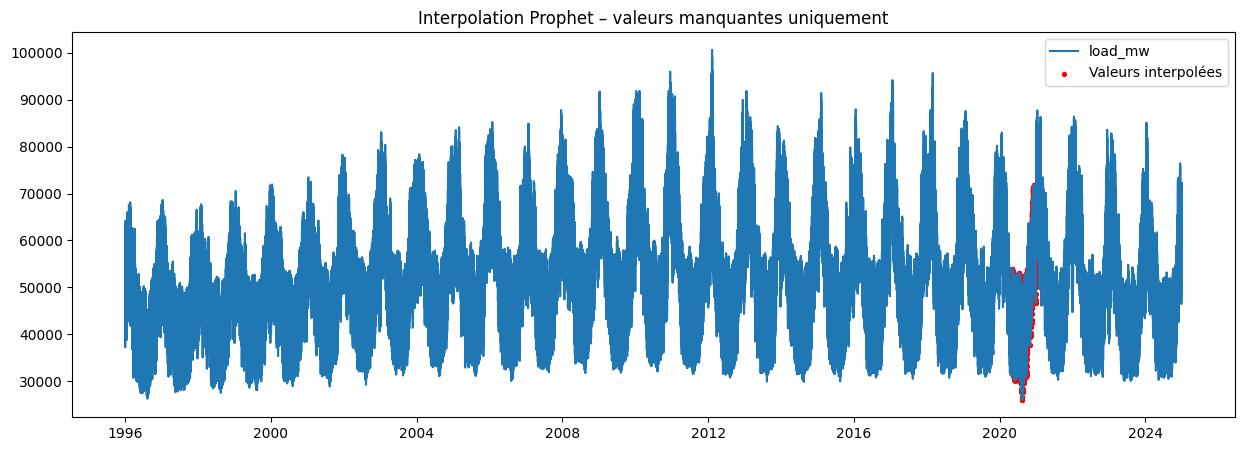

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(df_filled['datetime'], df_filled['load_mw'], label='load_mw')
plt.scatter(
    df.loc[df['load_mw'].isna(), 'datetime'],
    df_filled.loc[df['load_mw'].isna(), 'load_mw'],
    color='red',
    s=8,
    label='Valeurs interpolées'
)
plt.legend()
plt.title("Interpolation Prophet – valeurs manquantes uniquement")
plt.show()


## 5. Sorties

- `data/processed/consommation_clean.parquet`
- `data/processed/weather_national_hourly.parquet`
- `data/processed/dataset_model_hourly.parquet`
- `data/processed/dataset_model_hourly_prophetfilled.parquet`


## 📊 Data Quality Report

Cette section synthétise les principales caractéristiques et contrôles de qualité
des jeux de données utilisés avant l’étape de feature engineering.

### 🔹 Couverture temporelle

- **Consommation électrique**  
  - Période : 2010 → 2024  
  - Nombre d’années couvertes : 15 ans

- **Données météorologiques (nationales)**  
  - Période : 2010 → 2024 
  - Nombre d’années couvertes : 15 ans

- **Dataset final de modélisation**  
  - Période : 2010 → 2024 
  - Nombre d’années couvertes : 15 ans

### 🔹 Fréquence temporelle

- Consommation : semi-horaire agrégée à l’heure
- Météo : horaire
- Dataset final : **horaire**

### 🔹 Valeurs manquantes

- Les valeurs manquantes sont limitées et directement liées aux données source.
- Aucune interpolation automatique n’a été appliquée au dataset de référence.
- Une rupture structurelle est identifiée entre **mai et septembre 2020**, due à
  l’absence de données de consommation dans les fichiers source.

### 🔹 Décisions méthodologiques

- Le dataset sans interpolation constitue la **référence principale** pour la modélisation.
- Une reconstruction contrefactuelle via Prophet est utilisée uniquement à des fins
  de comparaison méthodologique et non comme solution opérationnelle.

### 🔹 Conclusion

Les données sont cohérentes, traçables et prêtes pour l’étape de feature engineering.
Les principales limitations sont identifiées et documentées, sans impact sur la
validité méthodologique de l’analyse.


<a id="section-03-feature-engineering"></a>

# 3. Feature Engineering

*Transition et contexte de la section suivante.*

<a id="section-03-exploration"></a>


# 03 — Exploration des données (après nettoyage)

On explore ici les datasets **propres** produits à la section précédente (cohérence temporelle, qualité, saisonnalité, premières figures).


In [59]:
import os


if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print(f"Current Working Directory: {os.getcwd()}")


Current Working Directory: /home/onyxia/france-grid-stress-prediction


In [60]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path('.').resolve() 
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
OUTPUT_FIG = PROJECT_ROOT / 'outputs' / 'figures'
OUTPUT_FIG.mkdir(parents=True, exist_ok=True)

CONS_PATH = DATA_PROCESSED / 'consommation_clean.parquet'
WEATHER_PATH = DATA_PROCESSED / 'weather_national_hourly.parquet'

CONS_PATH.exists(), WEATHER_PATH.exists()



(True, True)

## 1) Chargement

In [61]:
df_load = pd.read_parquet(CONS_PATH)
df_load['datetime'] = pd.to_datetime(df_load['datetime'])
df_load = df_load.sort_values('datetime').reset_index(drop=True)
df_load.head()

,datetime,load_mw
0,1996-01-01 00:00:00,40551
1,1996-01-01 00:30:00,39487
2,1996-01-01 01:00:00,39028
3,1996-01-01 01:30:00,38467
4,1996-01-01 02:00:00,37732


In [62]:
df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511248 entries, 0 to 511247
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  511248 non-null  datetime64[ns]
 1   load_mw   511248 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 7.8 MB


In [63]:
df_load[['datetime','load_mw']].describe(include='all')

,datetime,load_mw
count,511248,511248.000000
mean,2010-09-04 22:12:59.842269440,52519.213462
min,1996-01-01 00:00:00,25928.000000
25%,2003-04-16 17:52:30,43956.000000
50%,2010-07-31 11:45:00,51120.000000
75%,2017-11-14 05:37:30,59625.000000
max,2025-09-30 23:30:00,102098.000000
std,NaN,11361.382147


## 2) Couverture temporelle et continuité

In [64]:
start, end = df_load['datetime'].min(), df_load['datetime'].max()
freq_counts = df_load['datetime'].diff().value_counts().head(10)
start, end, freq_counts

(Timestamp('1996-01-01 00:00:00'),
 Timestamp('2025-09-30 23:30:00'),
 datetime
 0 days 00:30:00      511245
 154 days 00:30:00         1
 61 days 00:30:00          1
 Name: count, dtype: int64)

In [65]:
# Vérification des gaps horaires (attendu: 1H)
gaps = df_load['datetime'].diff().dropna()
largest_gaps = gaps.sort_values(ascending=False).head(20)
largest_gaps

426576   154 days 00:30:00
428016    61 days 00:30:00
1          0 days 00:30:00
340841     0 days 00:30:00
340839     0 days 00:30:00
340838     0 days 00:30:00
340837     0 days 00:30:00
340836     0 days 00:30:00
340835     0 days 00:30:00
340834     0 days 00:30:00
340833     0 days 00:30:00
340832     0 days 00:30:00
340831     0 days 00:30:00
340830     0 days 00:30:00
340829     0 days 00:30:00
340828     0 days 00:30:00
340827     0 days 00:30:00
340826     0 days 00:30:00
340825     0 days 00:30:00
340824     0 days 00:30:00
Name: datetime, dtype: timedelta64[ns]

In [66]:
# Nombre de valeurs manquantes sur la cible
df_load['load_mw'].isna().sum()

np.int64(0)

## 3) Visualisations rapides

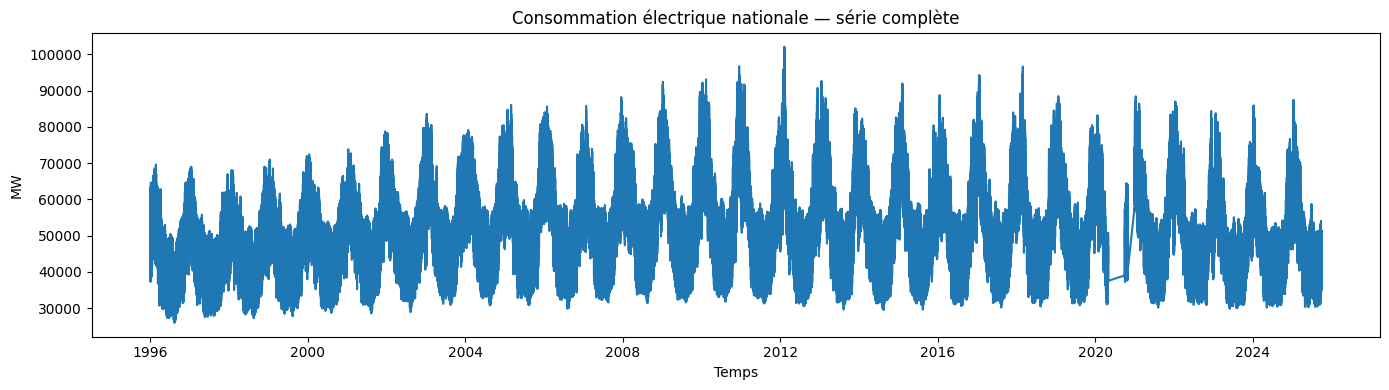

In [67]:
plt.figure(figsize=(14,4))
plt.plot(df_load['datetime'], df_load['load_mw'])
plt.title('Consommation électrique nationale — série complète')
plt.xlabel('Temps')
plt.ylabel('MW')
plt.tight_layout()
plt.savefig(OUTPUT_FIG / 'load_timeseries_full.png', dpi=150)
plt.show()

## 4) Météo agrégée (optionnel)

In [68]:
if WEATHER_PATH.exists():
    df_w = pd.read_parquet(WEATHER_PATH)
    if 'datetime' in df_w.columns:
        df_w['datetime'] = pd.to_datetime(df_w['datetime'])
    df_w = df_w.sort_values('datetime').reset_index(drop=True)
    display(df_w.head())
    display(df_w.info())
else:
    print('weather_national_hourly.parquet absent — section ignorée.')

,datetime,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,1996-01-01 00:00:00,5.840688,7.772773,0.0,0.0,80.68750
1,1996-01-01 01:00:00,5.745375,7.550241,0.0,0.0,82.12500
2,1996-01-01 02:00:00,5.671937,7.425267,0.0,0.0,86.93750
3,1996-01-01 03:00:00,5.643812,7.596300,0.0,0.0,86.40625
4,1996-01-01 04:00:00,5.551625,7.971026,0.0,0.0,87.12500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254568 entries, 0 to 254567
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datetime           254568 non-null  datetime64[ns]
 1   temperature_2m     254515 non-null  float64       
 2   wind_speed_10m     254515 non-null  float64       
 3   direct_radiation   254515 non-null  float64       
 4   diffuse_radiation  254515 non-null  float64       
 5   cloud_cover        254515 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 11.7 MB


None

## Compléments de visualisation (saisonnalité, profils hebdomadaires, tendance)


## Sommaire

<details open>
<summary>Afficher / masquer</summary>

- [Paramètres](#parametres)
- [1) Saisonnalité mensuelle (boxplots)](#1-saisonnalite-mensuelle-boxplots)
- [2) Profils moyens par jour de la semaine](#2-profils-moyens-par-jour-de-la-semaine)
- [3) Tendance globale de la consommation électrique](#3-tendance-globale-de-la-consommation-electrique)
- [Interprétation (à compléter)](#interpretation-a-completer)
- [Comparaison qualitative des modèles – semaines représentatives (hiver / été)](#comparaison-qualitative-des-modeles-semaines-representatives-hiver-ete)

</details>


In [69]:
import os


if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print(f"Current Working Directory: {os.getcwd()}")


Current Working Directory: /home/onyxia/france-grid-stress-prediction


In [70]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path('.').resolve()
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
OUTPUT_FIG = PROJECT_ROOT / 'outputs' / 'figures'
OUTPUT_FIG.mkdir(parents=True, exist_ok=True)

PATH = DATA_PROCESSED / 'consommation_clean.parquet'
assert PATH.exists(), f'Fichier introuvable: {PATH}'

df = pd.read_parquet(PATH)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)
df.head()

,datetime,load_mw
0,1996-01-01 00:00:00,40551
1,1996-01-01 00:30:00,39487
2,1996-01-01 01:00:00,39028
3,1996-01-01 01:30:00,38467
4,1996-01-01 02:00:00,37732


## Paramètres
<a id="parametres"></a>



In [71]:
YEAR = 2010  # changer ici si besoin
df_y = df[df['datetime'].dt.year == YEAR].copy()
df_y.shape, df_y['datetime'].min(), df_y['datetime'].max()

((17520, 2),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2010-12-31 23:30:00'))

<a id="1-saisonnalite-mensuelle-boxplots"></a>
## 1) Saisonnalité mensuelle (boxplots)





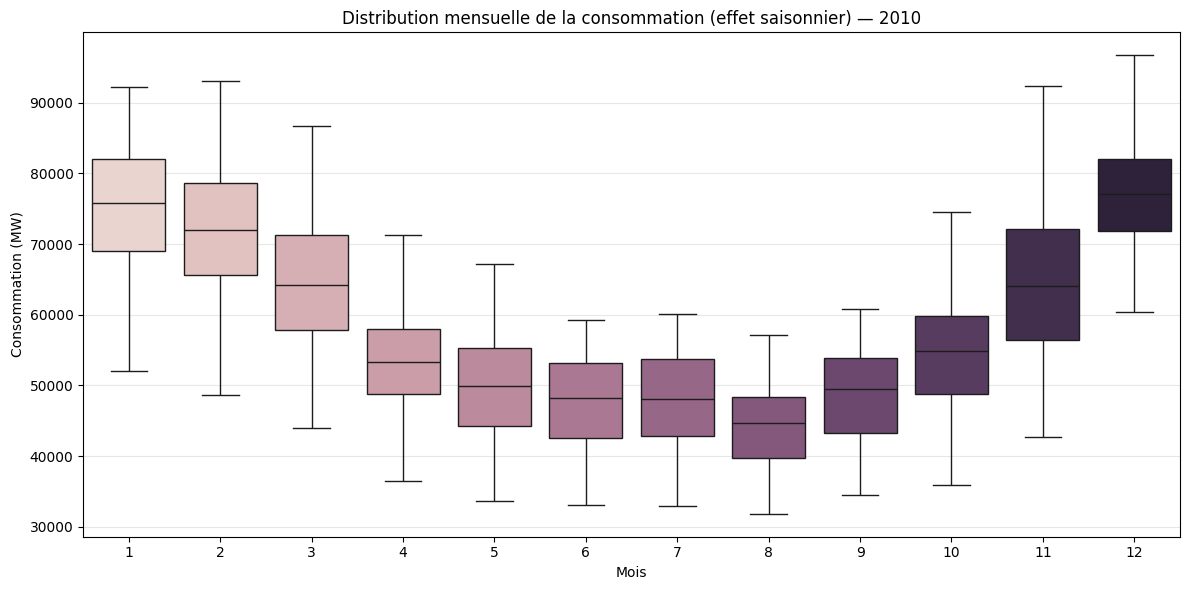

In [72]:
df_y['month'] = df_y['datetime'].dt.month

plt.figure(figsize=(12,6))
# seaborn: palette sans hue -> warning futur, donc on force hue=month et legend=False
sns.boxplot(data=df_y, x='month', y='load_mw', hue='month', legend=False)
plt.title(f'Distribution mensuelle de la consommation (effet saisonnier) — {YEAR}')
plt.xlabel('Mois')
plt.ylabel('Consommation (MW)')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_FIG / f'saisonnalite_mensuelle_{YEAR}.png', dpi=150)
plt.show()

## 2) Profils moyens par jour de la semaine

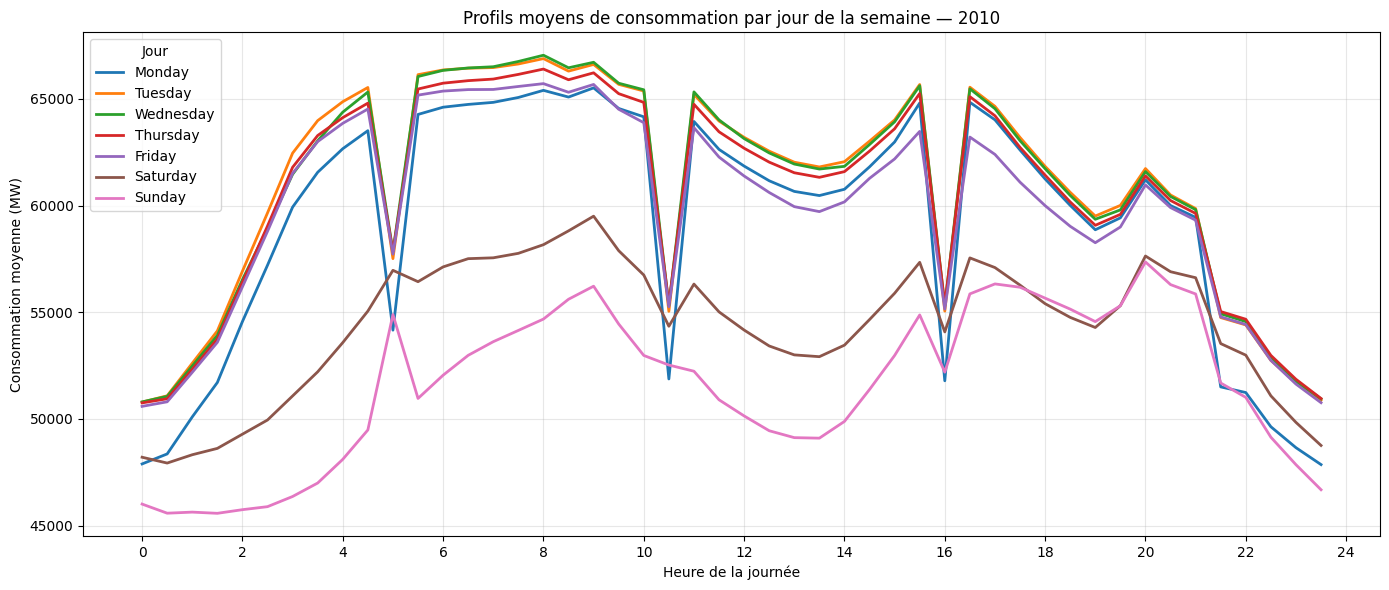

In [73]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_y['day_name'] = pd.Categorical(
    df_y['datetime'].dt.day_name(),
    categories=days_order,
    ordered=True
)

df_y['hour_float'] = df_y['datetime'].dt.hour + df_y['datetime'].dt.minute / 60

daily_profile = (
    df_y.groupby(['day_name', 'hour_float'], observed=True)['load_mw']
       .mean()
       .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(
    data=daily_profile,
    x='hour_float',
    y='load_mw',
    hue='day_name',
    linewidth=2
)
plt.title(f'Profils moyens de consommation par jour de la semaine — {YEAR}')
plt.xlabel('Heure de la journée')
plt.ylabel('Consommation moyenne (MW)')
plt.xticks(range(0, 25, 2))
plt.grid(True, alpha=0.3)
plt.legend(title='Jour', loc='upper left')
plt.tight_layout()
plt.savefig(OUTPUT_FIG / f'profils_hebdomadaires_{YEAR}.png', dpi=150)
plt.show()

## 3) Tendance globale de la consommation éléctrique


In [74]:

df_2010 = df[df["datetime"].dt.year == 2010].copy()

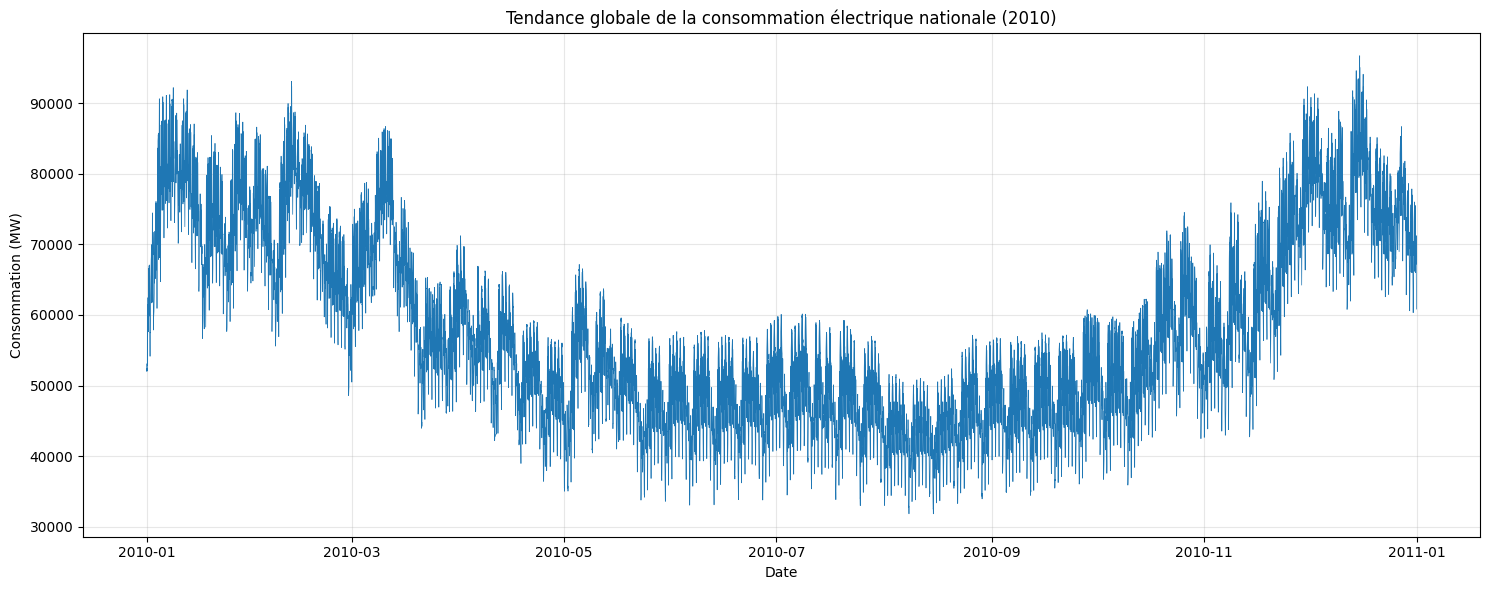

In [75]:
plt.figure(figsize=(15, 6))
plt.plot(df_2010["datetime"], df_2010["load_mw"], linewidth=0.5)

plt.title("Tendance globale de la consommation électrique nationale (2010)")
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("tendance_globale.png")
plt.show()

## Interprétation (à compléter)
- Saisonnalité: niveaux plus élevés en hiver, plus bas en été.
- Effet jour de semaine: jours ouvrés > week-end, avec profils intrajournaliers distincts.


# 03 — Feature Engineering

Objectif : construire un jeu de données "prêt modélisation" à partir du dataset horaire final
(consommation + météo), en créant des variables temporelles, retardées et dérivées,
sans fuite d'information (time leakage), puis en définissant un split temporel
(train/validation/test).

**Entrée :** `data/processed/dataset_model_hourly.parquet`  
**Sortie :** `data/processed/dataset_features.parquet` (ou splits séparés)


In [76]:
from pathlib import Path
import numpy as np
import pandas as pd

PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

IN_PATH = DATA_PROCESSED / "dataset_model_hourly.parquet"
OUT_PATH = DATA_PROCESSED / "dataset_features.parquet"

assert IN_PATH.exists(), f"Missing input: {IN_PATH}"


In [77]:
df = pd.read_parquet(IN_PATH)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

df.head()


,datetime,load_mw,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover
0,1996-01-01 00:00:00,40019.0,5.840688,7.772773,0.0,0.0,80.68750
1,1996-01-01 01:00:00,38747.5,5.745375,7.550241,0.0,0.0,82.12500
2,1996-01-01 02:00:00,37585.0,5.671937,7.425267,0.0,0.0,86.93750
3,1996-01-01 03:00:00,37354.5,5.643812,7.596300,0.0,0.0,86.40625
4,1996-01-01 04:00:00,37218.5,5.551625,7.971026,0.0,0.0,87.12500


## Verification de cohérence

Vérifications minimales :
- période couverte (min/max)
- fréquence horaire (pas dominant)
- valeurs manquantes par colonne


In [78]:
print("Min datetime:", df["datetime"].min())
print("Max datetime:", df["datetime"].max())
print("N rows:", len(df))

# fréquence dominante
dt_diff = df["datetime"].diff().value_counts().head(5)
print("\nTop time diffs:")
print(dt_diff)

# NA par colonne
na_pct = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
print("\nMissing values (%):")
print(na_pct.head(20))


Min datetime: 1996-01-01 00:00:00
Max datetime: 2024-12-31 23:00:00
N rows: 254232

Top time diffs:
datetime
0 days 01:00:00    254231
Name: count, dtype: int64

Missing values (%):
load_mw              2.03
datetime             0.00
temperature_2m       0.00
wind_speed_10m       0.00
direct_radiation     0.00
diffuse_radiation    0.00
cloud_cover          0.00
dtype: float64


## Définition de la cible

On commence avec une cible "à l’heure" : `y = load_mw`.
Ensuite, on pourra créer une variante H+24 : `y_h24 = load_mw(t+24)`.


In [79]:
TARGET_COL = "load_mw"
assert TARGET_COL in df.columns, f"Missing target column: {TARGET_COL}"

df["y"] = df[TARGET_COL].astype(float)

# df["y_h24"] = df["y"].shift(-24)


## Features calendaires

But : capturer les effets "humains" (heures, jours ouvrés/week-end) et la saisonnalité.


In [80]:
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.weekday  # 0=Monday
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
df["month"] = df["datetime"].dt.month
df["dayofyear"] = df["datetime"].dt.dayofyear

# Encodage cyclique (optionnel mais propre)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["doy_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365.25)


## Lags

But : donner au modèle l'inertie de la consommation (heure précédente, veille, semaine).
Attention : cela crée des NA au début de la série (normal).


In [81]:
LAGS_H = [1, 24, 48, 168]

for lag in LAGS_H:
    df[f"load_lag_{lag}h"] = df["y"].shift(lag)


## Rolling statistics

But : fournir un contexte recent (niveau moyen, variabilité).
Fenêtres typiques : 24h, 7j.


In [82]:
ROLL_WINDOWS = [24, 168]

for w in ROLL_WINDOWS:
    df[f"load_roll_mean_{w}h"] = df["y"].shift(1).rolling(w).mean()
    df[f"load_roll_std_{w}h"] = df["y"].shift(1).rolling(w).std()


## Features météo dérivées

On calcule des degrés-jours chauffage (HDD) et climatisation (CDD) si une température existe.
Adapte `TEMP_COL` selon le nom réel dans ton dataset.


In [83]:
# Adapte ce nom à ta colonne température réelle (ex: "temperature", "temp", "t2m", etc.)
TEMP_COL_CANDIDATES = [c for c in df.columns if "temp" in c.lower()]
print("Temp candidates:", TEMP_COL_CANDIDATES[:10])

# Exemple : tu fixes explicitement la colonne
# TEMP_COL = "temp"
TEMP_COL = None

if TEMP_COL and TEMP_COL in df.columns:
    df["hdd_18"] = (18 - df[TEMP_COL]).clip(lower=0)
    df["cdd_22"] = (df[TEMP_COL] - 22).clip(lower=0)


Temp candidates: ['temperature_2m']


## Interactions (optionnel)

Ajouter peu d’interactions (2–3 max) si elles sont justifiées.


In [84]:
# Exemple si TEMP_COL existe
# if TEMP_COL and TEMP_COL in df.columns:
#     df["temp_x_weekend"] = df[TEMP_COL] * df["is_weekend"]
#     df["temp_x_hour"] = df[TEMP_COL] * df["hour"]


## Gestion des valeurs manquantes

On applique une règle simple : suppression des lignes contenant des NA dans les variables
utilisées pour l'entraînement. On documente combien de lignes sont retirées.


In [85]:
# Colonnes features (exclure datetime et target)
feature_cols = [
    c for c in df.columns
    if c not in {"datetime", TARGET_COL, "y"} and not c.startswith("y_")
]

before = len(df)
df_feat = df.dropna(subset=feature_cols + ["y"]).copy()
after = len(df_feat)

print("Rows before:", before)
print("Rows after dropna:", after)
print("Dropped:", before - after)


Rows before: 254232
Rows after dropna: 248568
Dropped: 5664


## Split temporel

Découpage chronologique strict. Exemple :
- train : 2010–2018
- valid : 2019
- test  : 2021–2022

2020 peut être exclue (trou + période atypique) ou traitée à part.
Adapte selon ta disponibilité réelle (min/max).


In [86]:
df_feat["year"] = df_feat["datetime"].dt.year

def assign_split(y: int) -> str:
    if 2010 <= y <= 2018:
        return "train"
    if y == 2019:
        return "valid"
    if 2021 <= y <= 2022:
        return "test"
    return "ignore"

df_feat["split"] = df_feat["year"].apply(assign_split)

print(df_feat["split"].value_counts())


split
ignore    143568
train      78888
test       17352
valid       8760
Name: count, dtype: int64


## Export

On exporte un dataset unique avec une colonne `split`.


In [87]:
keep_cols = ["datetime", "y", "split"] + feature_cols
df_out = df_feat[keep_cols].copy()

OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df_out.to_parquet(OUT_PATH, index=False)

print("Saved:", OUT_PATH)
print(df_out.head())


Saved: /home/onyxia/france-grid-stress-prediction/data/processed/dataset_features.parquet
               datetime        y   split  temperature_2m  wind_speed_10m  \
168 1996-01-08 00:00:00  42132.0  ignore        6.440688       12.455561   
169 1996-01-08 01:00:00  44654.0  ignore        6.223500       12.699880   
170 1996-01-08 02:00:00  50229.5  ignore        6.071938       12.454559   
171 1996-01-08 03:00:00  57273.5  ignore        6.000063       12.419657   
172 1996-01-08 04:00:00  58906.0  ignore        6.029750       12.732390   

     direct_radiation  diffuse_radiation  cloud_cover  hour  dayofweek  ...  \
168               0.0                0.0     51.71875     0          0  ...   
169               0.0                0.0     49.81250     1          0  ...   
170               0.0                0.0     53.90625     2          0  ...   
171               0.0                0.0     58.03125     3          0  ...   
172               0.0                0.0     59.65625     

In [88]:
report = (
    df_out.groupby("split")
    .agg(
        n_rows=("y", "size"),
        start=("datetime", "min"),
        end=("datetime", "max"),
    )
    .sort_index()
)
report


,n_rows,start,end
split,,,
ignore,143568,1996-01-08,2024-12-31 23:00:00
test,17352,2021-01-08,2022-12-31 23:00:00
train,78888,2010-01-01,2018-12-31 23:00:00
valid,8760,2019-01-01,2019-12-31 23:00:00


## Conclusion

Le dataset `dataset_features.parquet` contient :
- la cible `y`
- des variables calendaires + retardées + glissantes (+ météo dérivées si disponibles)
- un split temporel strict (train/valid/test)

La prochaine étape (`04_modeling.ipynb`) consiste à entraîner des modèles de référence
(naïf, régression linéaire), puis des modèles ML (XGBoost/LightGBM), et comparer les performances.


<a id="section-04-feature-engineering-prophet"></a>

# 4. Feature Engineering – Prophet

*Transition et contexte de la section suivante.*

# 03 — Feature Engineering

Objectif : construire un jeu de données "prêt modélisation" à partir du dataset horaire final
(consommation + météo), en créant des variables temporelles, retardées et dérivées,
sans fuite d'information (time leakage), puis en définissant un split temporel
(train/validation/test).

**Entrée :** `data/processed/dataset_model_hourly.parquet`  
**Sortie :** `data/processed/dataset_features.parquet` (ou splits séparés)


In [89]:
from pathlib import Path
import numpy as np
import pandas as pd

PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

IN_PATH = DATA_PROCESSED / "dataset_model_hourly_prophetfilled.parquet"
OUT_PATH = DATA_PROCESSED / "dataset_features_prophetfilled.parquet"

assert IN_PATH.exists(), f"Missing input: {IN_PATH}"


In [90]:
df = pd.read_parquet(IN_PATH)
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

df.head()


,datetime,load_mw,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover,filled_by_prophet
0,1996-01-01 00:00:00,40019.0,5.840688,7.772773,0.0,0.0,80.68750,False
1,1996-01-01 01:00:00,38747.5,5.745375,7.550241,0.0,0.0,82.12500,False
2,1996-01-01 02:00:00,37585.0,5.671937,7.425267,0.0,0.0,86.93750,False
3,1996-01-01 03:00:00,37354.5,5.643812,7.596300,0.0,0.0,86.40625,False
4,1996-01-01 04:00:00,37218.5,5.551625,7.971026,0.0,0.0,87.12500,False


## Verification de cohérence

Vérifications minimales :
- période couverte (min/max)
- fréquence horaire (pas dominant)
- valeurs manquantes par colonne


In [91]:
print("Min datetime:", df["datetime"].min())
print("Max datetime:", df["datetime"].max())
print("N rows:", len(df))

# fréquence dominante
dt_diff = df["datetime"].diff().value_counts().head(5)
print("\nTop time diffs:")
print(dt_diff)

# NA par colonne
na_pct = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
print("\nMissing values (%):")
print(na_pct.head(20))


Min datetime: 1996-01-01 00:00:00
Max datetime: 2024-12-31 23:00:00
N rows: 254232

Top time diffs:
datetime
0 days 01:00:00    254231
Name: count, dtype: int64

Missing values (%):
datetime             0.0
load_mw              0.0
temperature_2m       0.0
wind_speed_10m       0.0
direct_radiation     0.0
diffuse_radiation    0.0
cloud_cover          0.0
filled_by_prophet    0.0
dtype: float64


## Définition de la cible

On commence avec une cible "à l’heure" : `y = load_mw`.
Ensuite, on pourra créer une variante H+24 : `y_h24 = load_mw(t+24)`.


In [92]:
TARGET_COL = "load_mw"
assert TARGET_COL in df.columns, f"Missing target column: {TARGET_COL}"

df["y"] = df[TARGET_COL].astype(float)

# df["y_h24"] = df["y"].shift(-24)


## Features calendaires

But : capturer les effets "humains" (heures, jours ouvrés/week-end) et la saisonnalité.


In [93]:
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.weekday  # 0=Monday
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
df["month"] = df["datetime"].dt.month
df["dayofyear"] = df["datetime"].dt.dayofyear

# Encodage cyclique (optionnel mais propre)
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["doy_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365.25)


## Lags

But : donner au modèle l'inertie de la consommation (heure précédente, veille, semaine).
Attention : cela crée des NA au début de la série (normal).


In [94]:
LAGS_H = [1, 24, 48, 168]

for lag in LAGS_H:
    df[f"load_lag_{lag}h"] = df["y"].shift(lag)


## Rolling statistics

But : fournir un contexte recent (niveau moyen, variabilité).
Fenêtres typiques : 24h, 7j.


In [95]:
ROLL_WINDOWS = [24, 168]

for w in ROLL_WINDOWS:
    df[f"load_roll_mean_{w}h"] = df["y"].shift(1).rolling(w).mean()
    df[f"load_roll_std_{w}h"] = df["y"].shift(1).rolling(w).std()


## Features météo dérivées

On calcule des degrés-jours chauffage (HDD) et climatisation (CDD) si une température existe.
Adapte `TEMP_COL` selon le nom réel dans ton dataset.


In [96]:
# Adapte ce nom à ta colonne température réelle (ex: "temperature", "temp", "t2m", etc.)
TEMP_COL_CANDIDATES = [c for c in df.columns if "temp" in c.lower()]
print("Temp candidates:", TEMP_COL_CANDIDATES[:10])

# Exemple : tu fixes explicitement la colonne
# TEMP_COL = "temp"
TEMP_COL = None

if TEMP_COL and TEMP_COL in df.columns:
    df["hdd_18"] = (18 - df[TEMP_COL]).clip(lower=0)
    df["cdd_22"] = (df[TEMP_COL] - 22).clip(lower=0)


Temp candidates: ['temperature_2m']


## Interactions (optionnel)

Ajouter peu d’interactions (2–3 max) si elles sont justifiées.


In [97]:
# Exemple si TEMP_COL existe
# if TEMP_COL and TEMP_COL in df.columns:
#     df["temp_x_weekend"] = df[TEMP_COL] * df["is_weekend"]
#     df["temp_x_hour"] = df[TEMP_COL] * df["hour"]


## Gestion des valeurs manquantes

On applique une règle simple : suppression des lignes contenant des NA dans les variables
utilisées pour l'entraînement. On documente combien de lignes sont retirées.


In [98]:
# Colonnes features (exclure datetime et target)
feature_cols = [
    c for c in df.columns
    if c not in {"datetime", TARGET_COL, "y"} and not c.startswith("y_")
]

before = len(df)
df_feat = df.dropna(subset=feature_cols + ["y"]).copy()
after = len(df_feat)

print("Rows before:", before)
print("Rows after dropna:", after)
print("Dropped:", before - after)


Rows before: 254232
Rows after dropna: 254064
Dropped: 168


## Split temporel

Découpage chronologique strict. Exemple :
- train : 2010–2018
- valid : 2019
- test  : 2021–2022

2020 peut être exclue (trou + période atypique) ou traitée à part.
Adapte selon ta disponibilité réelle (min/max).


In [99]:
df_feat["year"] = df_feat["datetime"].dt.year

def assign_split(y: int) -> str:
    if 2010 <= y <= 2018:
        return "train"
    if y == 2019:
        return "valid"
    if 2021 <= y <= 2022:
        return "test"
    return "ignore"

df_feat["split"] = df_feat["year"].apply(assign_split)

print(df_feat["split"].value_counts())


split
ignore    148896
train      78888
test       17520
valid       8760
Name: count, dtype: int64


## Export

On exporte un dataset unique avec une colonne `split`.


In [100]:
keep_cols = ["datetime", "y", "split"] + feature_cols
df_out = df_feat[keep_cols].copy()

OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df_out.to_parquet(OUT_PATH, index=False)

print("Saved:", OUT_PATH)
print(df_out.head())


Saved: /home/onyxia/france-grid-stress-prediction/data/processed/dataset_features_prophetfilled.parquet
               datetime        y   split  temperature_2m  wind_speed_10m  \
168 1996-01-08 00:00:00  42132.0  ignore        6.440688       12.455561   
169 1996-01-08 01:00:00  44654.0  ignore        6.223500       12.699880   
170 1996-01-08 02:00:00  50229.5  ignore        6.071938       12.454559   
171 1996-01-08 03:00:00  57273.5  ignore        6.000063       12.419657   
172 1996-01-08 04:00:00  58906.0  ignore        6.029750       12.732390   

     direct_radiation  diffuse_radiation  cloud_cover  filled_by_prophet  \
168               0.0                0.0     51.71875              False   
169               0.0                0.0     49.81250              False   
170               0.0                0.0     53.90625              False   
171               0.0                0.0     58.03125              False   
172               0.0                0.0     59.65625      

In [101]:
report = (
    df_out.groupby("split")
    .agg(
        n_rows=("y", "size"),
        start=("datetime", "min"),
        end=("datetime", "max"),
    )
    .sort_index()
)
report


,n_rows,start,end
split,,,
ignore,148896,1996-01-08,2024-12-31 23:00:00
test,17520,2021-01-01,2022-12-31 23:00:00
train,78888,2010-01-01,2018-12-31 23:00:00
valid,8760,2019-01-01,2019-12-31 23:00:00


## Conclusion

Le dataset `dataset_features.parquet` contient :
- la cible `y`
- des variables calendaires + retardées + glissantes (+ météo dérivées si disponibles)
- un split temporel strict (train/valid/test)

La prochaine étape (`04_modeling.ipynb`) consiste à entraîner des modèles de référence
(naïf, régression linéaire), puis des modèles ML (XGBoost/LightGBM), et comparer les performances.


<a id="section-05-modeling"></a>

# 5. Modélisation

*Transition et contexte de la section suivante.*

# 04 — Modeling and Forecasting

Objectif : entraîner, comparer et évaluer plusieurs modèles de prévision de la
consommation électrique nationale à partir du dataset enrichi par feature engineering.

Les modèles sont évalués :
- sur des données réelles (baseline)
- sur des données reconstruites (Prophet-filled)
- avec une séparation temporelle stricte


In [102]:
!pip install prophet
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor


## Chargement des datasets de features

Deux jeux sont utilisés :
- dataset de référence (sans interpolation)
- dataset reconstruit par Prophet (contrefactuel)


In [103]:
PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

BASELINE_PATH = DATA_PROCESSED / "dataset_features.parquet"
PROPHET_PATH  = DATA_PROCESSED / "dataset_features_prophetfilled.parquet"

df_base = pd.read_parquet(BASELINE_PATH)
df_prophet = pd.read_parquet(PROPHET_PATH)

df_base.head()


,datetime,y,split,temperature_2m,wind_speed_10m,direct_radiation,diffuse_radiation,cloud_cover,hour,dayofweek,...,doy_sin,doy_cos,load_lag_1h,load_lag_24h,load_lag_48h,load_lag_168h,load_roll_mean_24h,load_roll_std_24h,load_roll_mean_168h,load_roll_std_168h
0,1996-01-08 00:00:00,42132.0,ignore,6.440688,12.455561,0.0,0.0,51.71875,0,0,...,0.137185,0.990545,42460.5,40350.5,44907.0,40019.0,44714.041667,3377.890273,51106.970238,6991.195474
1,1996-01-08 01:00:00,44654.0,ignore,6.223500,12.699880,0.0,0.0,49.81250,1,0,...,0.137185,0.990545,42132.0,39624.0,44772.5,38747.5,44788.270833,3296.424189,51119.547619,6973.005432
2,1996-01-08 02:00:00,50229.5,ignore,6.071938,12.454559,0.0,0.0,53.90625,2,0,...,0.137185,0.990545,44654.0,39306.0,45506.0,37585.0,44997.854167,3108.345130,51154.705357,6924.977130
3,1996-01-08 03:00:00,57273.5,ignore,6.000063,12.419657,0.0,0.0,58.03125,3,0,...,0.137185,0.990545,50229.5,39994.5,47983.5,37354.5,45453.000000,3037.610231,51229.970238,6844.860782
4,1996-01-08 04:00:00,58906.0,ignore,6.029750,12.732390,0.0,0.0,59.65625,4,0,...,0.137185,0.990545,57273.5,41259.5,50141.5,37218.5,46172.958333,3669.566874,51348.535714,6775.235712


## Séparation train / validation / test

La séparation temporelle a été définie lors du feature engineering.


In [104]:
TARGET = "y"
META_COLS = ["datetime", "split"]

FEATURES = [c for c in df_base.columns if c not in META_COLS + [TARGET]]

def split_data(df):
    train = df[df["split"] == "train"]
    valid = df[df["split"] == "valid"]
    test  = df[df["split"] == "test"]

    return (
        train[FEATURES], train[TARGET],
        valid[FEATURES], valid[TARGET],
        test[FEATURES],  test[TARGET],
    )


## Fonctions d’évaluation


In [105]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mse),
    }


## Baseline naïve — persistance J-1


In [106]:
def naive_forecast(df):
    return df["load_lag_24h"]

results = []


In [107]:
for name, df in [("Baseline", df_base), ("ProphetFilled", df_prophet)]:
    test = df[df["split"] == "test"]
    y_pred = test["load_lag_24h"]
    scores = evaluate(test[TARGET], y_pred)
    scores["model"] = "Naive (lag 24h)"
    scores["dataset"] = name
    results.append(scores)

print(results)


[{'MAE': 2631.883961502997, 'RMSE': np.float64(3856.414907245179), 'model': 'Naive (lag 24h)', 'dataset': 'Baseline'}, {'MAE': 2636.2107754561875, 'RMSE': np.float64(3863.588449314868), 'model': 'Naive (lag 24h)', 'dataset': 'ProphetFilled'}]



## Modèle Naïf résultat

Le modèle naïf, basé sur une persistance à 24 heures, constitue une référence
simple mais informative. Il atteint une erreur absolue moyenne d’environ 2,6 GW,
ce qui correspond à une erreur relative de l’ordre de quelques pourcents.
La performance très proche obtenue sur les données réelles et reconstruites
confirme que ce modèle ne bénéficie pas du remplissage artificiel de l’année 2020
et constitue un plancher robuste pour la comparaison des modèles plus complexes.


## Régression linéaire (baseline interprétable)


In [108]:
def run_linear_models(df, dataset_name):
    Xtr, ytr, Xv, yv, Xt, yt = split_data(df)

    for model, label in [
        (LinearRegression(), "Linear"),
        (Ridge(alpha=1.0), "Ridge"),
    ]:
        model.fit(Xtr, ytr)
        y_pred = model.predict(Xt)

        scores = evaluate(yt, y_pred)
        scores["model"] = label
        scores["dataset"] = dataset_name
        results.append(scores)


In [109]:
run_linear_models(df_base, "Baseline")
run_linear_models(df_prophet, "ProphetFilled")


In [110]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df


,MAE,RMSE,model,dataset
0,2631.883962,3856.414907,Naive (lag 24h),Baseline
1,2636.210775,3863.588449,Naive (lag 24h),ProphetFilled
2,1511.500426,1928.117643,Linear,Baseline
3,1511.498304,1928.118044,Ridge,Baseline
4,1519.731979,1938.751537,Linear,ProphetFilled
5,1519.730281,1938.752616,Ridge,ProphetFilled


Les modèles linéaires améliorent très nettement les performances par rapport au
modèle naïf, avec une réduction d’environ 40 % de la MAE et de 50 % de la RMSE.
Ce gain confirme que les variables issues du feature engineering contiennent une
information explicative forte sur la consommation électrique.

Les performances très proches entre la régression linéaire et le modèle Ridge
suggèrent une colinéarité modérée entre les variables, sans impact significatif
sur la stabilité des prédictions. Enfin, l’utilisation de données reconstruites
par Prophet n’apporte pas d’amélioration notable, ce qui confirme que ce
traitement n’est pas déterminant pour les modèles multivariés considérés ici.


## XGBoost — modèle principal


In [111]:
def run_xgboost(df, dataset_name):
    Xtr, ytr, Xv, yv, Xt, yt = split_data(df)

    model = XGBRegressor(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(Xtr, ytr)
    y_pred = model.predict(Xt)

    scores = evaluate(yt, y_pred)
    scores["model"] = "XGBoost"
    scores["dataset"] = dataset_name
    results.append(scores)

    return model


In [112]:
xgb_base = run_xgboost(df_base, "Baseline")
xgb_prophet = run_xgboost(df_prophet, "ProphetFilled")


In [113]:
# On refait les splits pour récupérer train / val / test
xtr_b, ytr_b, xv_b, yv_b, xt_b, yt_b = split_data(df_base)
xtr_p, ytr_p, xv_p, yv_p, xt_p, yt_p = split_data(df_prophet)


In [114]:
def diagnose_fit(model, xtr, ytr, xv, yv, xt, yt, name):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    yhat_tr = model.predict(xtr)
    yhat_v  = model.predict(xv)
    yhat_t  = model.predict(xt)

    def scores(y, yhat):
        mse = mean_squared_error(y, yhat)
        return {
            "MAE": mean_absolute_error(y, yhat),
            "RMSE": np.sqrt(mse)
        }

    res = {
        "Model": name,
        "Train_MAE": scores(ytr, yhat_tr)["MAE"],
        "Val_MAE": scores(yv,  yhat_v)["MAE"],
        "Test_MAE": scores(yt, yhat_t)["MAE"],
        "Val/Train": scores(yv, yhat_v)["MAE"] / scores(ytr, yhat_tr)["MAE"]
    }

    return res


In [115]:
diagnostics = []

diagnostics.append(
    diagnose_fit(xgb_base, xtr_b, ytr_b, xv_b, yv_b, xt_b, yt_b, "XGBoost Baseline")
)

diagnostics.append(
    diagnose_fit(xgb_prophet, xtr_p, ytr_p, xv_p, yv_p, xt_p, yt_p, "XGBoost ProphetFilled")
)

diag_df = pd.DataFrame(diagnostics)
diag_df


,Model,Train_MAE,Val_MAE,Test_MAE,Val/Train
0,XGBoost Baseline,485.208624,570.375307,643.134932,1.175526
1,XGBoost ProphetFilled,485.208624,570.375307,645.144268,1.175526


L’augmentation de la profondeur à 10 entraîne une forte réduction de l’erreur sur le jeu d’entraînement, mais provoque un sur-apprentissage marqué, mis en évidence par un ratio validation/entraînement supérieur à 2. Le modèle avec max_depth=6 offre un meilleur compromis biais-variance.

## Prophet comme modèle de référence temporelle

Prophet est utilisé ici comme modèle univarié, sans variables exogènes,
afin de servir de point de comparaison avec les approches multivariées.


In [116]:
from prophet import Prophet


In [117]:
def run_prophet(df, dataset_name):
    train = df[df["split"] == "train"][["datetime", "y"]]
    test = df[df["split"] == "test"][["datetime", "y"]]

    prophet_df = train.rename(columns={"datetime": "ds", "y": "y"})

    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
    m.fit(prophet_df)

    future = test[["datetime"]].rename(columns={"datetime": "ds"})
    forecast = m.predict(future)

    scores = evaluate(test["y"], forecast["yhat"])
    scores["model"] = "Prophet"
    scores["dataset"] = dataset_name
    results.append(scores)


In [118]:
run_prophet(df_base, "Baseline")


20:20:11 - cmdstanpy - INFO - Chain [1] start processing
20:21:24 - cmdstanpy - INFO - Chain [1] done processing


## Comparaison globale des modèles


In [119]:
results_df = pd.DataFrame(results)
results_df.sort_values(["dataset", "MAE"])


,MAE,RMSE,model,dataset
6,643.134932,861.392896,XGBoost,Baseline
3,1511.498304,1928.118044,Ridge,Baseline
2,1511.500426,1928.117643,Linear,Baseline
0,2631.883962,3856.414907,Naive (lag 24h),Baseline
8,4279.988601,5607.577922,Prophet,Baseline
7,645.144268,864.810886,XGBoost,ProphetFilled
5,1519.730281,1938.752616,Ridge,ProphetFilled
4,1519.731979,1938.751537,Linear,ProphetFilled
1,2636.210775,3863.588449,Naive (lag 24h),ProphetFilled


In [120]:
from pathlib import Path
import joblib

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

joblib.dump(xgb_base, MODEL_DIR / "xgb_model.joblib")

['models/xgb_model.joblib']

<a id="section-06-analysis"></a>

# 6. Analyse des résultats

*Transition et contexte de la section suivante.*

# 05 — Analyse descriptive (figures pour rapport)
Ce notebook produit des **figures interprétables** (saisonnalité mensuelle, profils journaliers moyens). Ces graphiques sont destinés à être réutilisés dans un rapport/soutenance.


## Comparaison qualitative des modèles – semaines représentatives (hiver / été)


Test range: 2021-01-08 00:00:00 → 2022-12-31 23:00:00


20:21:35 - cmdstanpy - INFO - Chain [1] start processing
20:22:48 - cmdstanpy - INFO - Chain [1] done processing


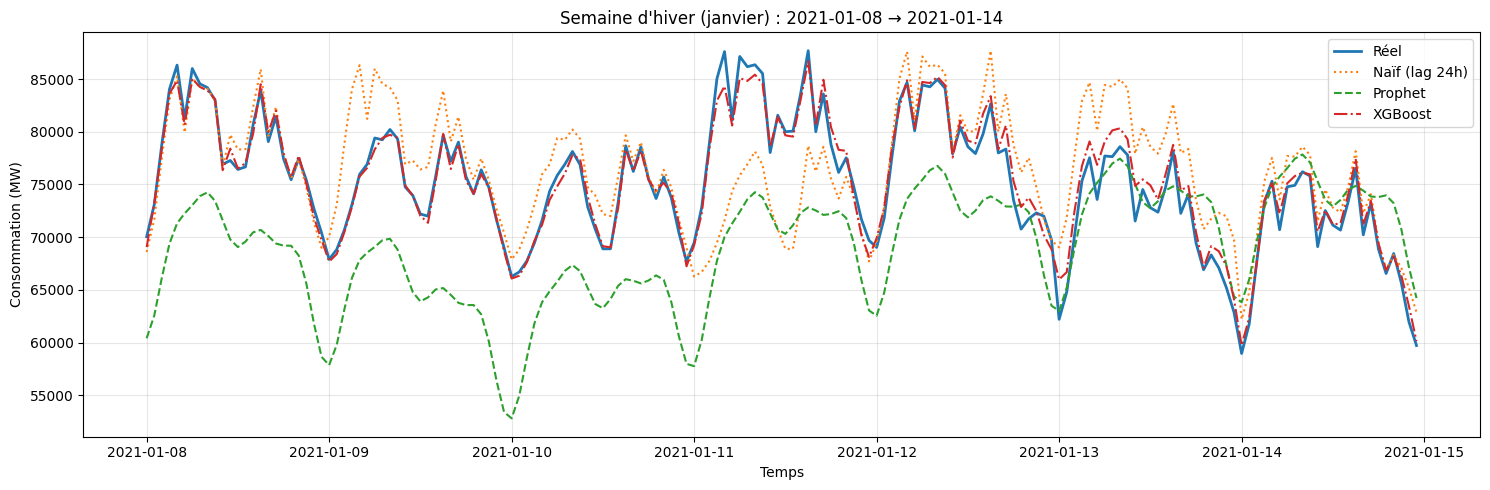

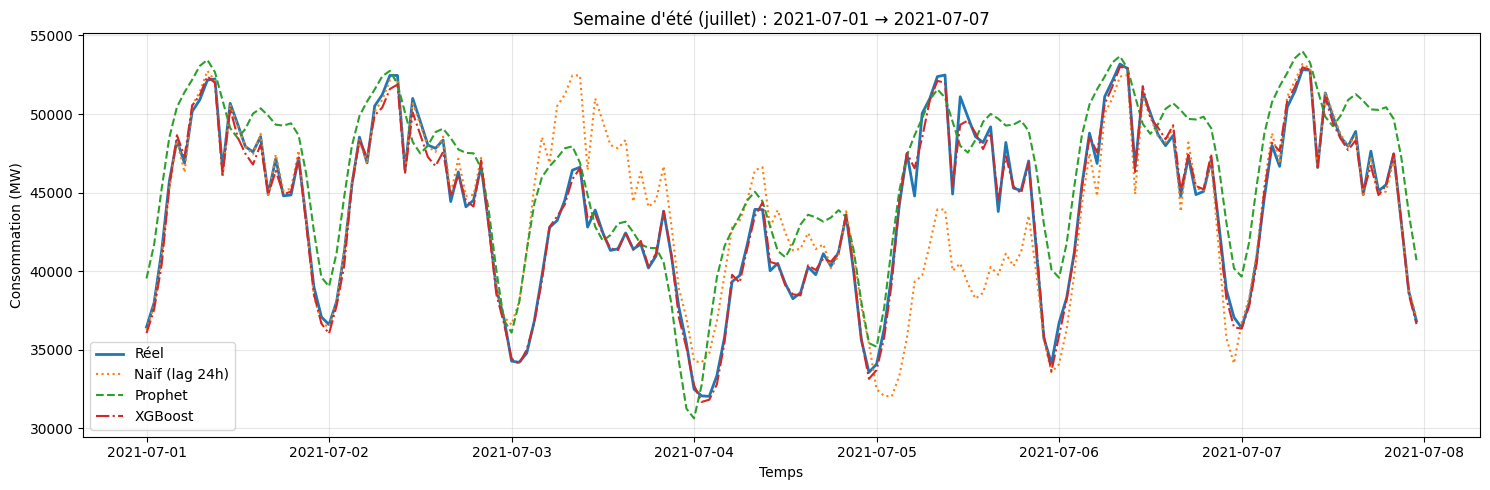

In [121]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from prophet import Prophet



# 0) Load features dataset (choose baseline or prophetfilled)

PROJECT_ROOT = Path("/home/onyxia/france-grid-stress-prediction")
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

FEATURES_PATH = DATA_PROCESSED / "dataset_features.parquet"
# FEATURES_PATH = DATA_PROCESSED / "dataset_features_prophetfilled.parquet"

df = pd.read_parquet(FEATURES_PATH).copy()
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")

TARGET = "y"
META_COLS = ["datetime", "split"]

# Naive needs this column
assert "load_lag_24h" in df.columns, "Missing feature 'load_lag_24h' for naive baseline."
assert TARGET in df.columns, f"Missing target '{TARGET}'."

FEATURES = [c for c in df.columns if c not in META_COLS + [TARGET]]

train = df[df["split"] == "train"].copy()
test  = df[df["split"] == "test"].copy()

X_train, y_train = train[FEATURES], train[TARGET]
X_test,  y_test  = test[FEATURES],  test[TARGET]

print("Test range:", test["datetime"].min(), "→", test["datetime"].max())



# 1) Train XGBoost and predict on test

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)



# 2) Train Prophet (univariate) and predict on test datetimes

prophet_train = train[["datetime", "y"]].rename(columns={"datetime": "ds", "y": "y"})
prophet_test_ds = test[["datetime"]].rename(columns={"datetime": "ds"})

m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(prophet_train)

forecast = m.predict(prophet_test_ds)
pred_prophet = forecast["yhat"].values



# 3) Build a single aligned dataframe for plotting

plot_all = test[["datetime", "y", "load_lag_24h"]].copy()
plot_all["pred_naive"] = plot_all["load_lag_24h"].astype(float)
plot_all["pred_prophet"] = pred_prophet
plot_all["pred_xgb"] = pred_xgb



# 4) Helper: pick a valid week inside test for a given month 

def select_week_in_month(df_plot: pd.DataFrame, month: int, days: int = 7) -> tuple[pd.Timestamp, pd.Timestamp, pd.DataFrame]:
    dfi = df_plot[df_plot["datetime"].dt.month == month].copy()
    if dfi.empty:
        raise ValueError(f"No data for month={month} in test set.")
    start = dfi["datetime"].min().normalize()
    end = start + pd.Timedelta(days=days)
    week = df_plot[(df_plot["datetime"] >= start) & (df_plot["datetime"] < end)].copy()
    if week.empty:
        raise ValueError(f"Week selection failed for month={month}.")
    return start, end, week


def plot_week(week: pd.DataFrame, title: str):
    plt.figure(figsize=(15, 5))
    plt.plot(week["datetime"], week["y"], label="Réel", linewidth=2)
    plt.plot(week["datetime"], week["pred_naive"], label="Naïf (lag 24h)", linestyle=":")
    plt.plot(week["datetime"], week["pred_prophet"], label="Prophet", linestyle="--")
    plt.plot(week["datetime"], week["pred_xgb"], label="XGBoost", linestyle="-.")
    plt.title(title)
    plt.xlabel("Temps")
    plt.ylabel("Consommation (MW)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# 5) Plot one winter week  and one summer week 

start_jan, end_jan, week_jan = select_week_in_month(plot_all, month=1, days=7)
plot_week(week_jan, f"Semaine d'hiver (janvier) : {start_jan.date()} → {(end_jan - pd.Timedelta(days=1)).date()}")

start_jul, end_jul, week_jul = select_week_in_month(plot_all, month=7, days=7)
plot_week(week_jul, f"Semaine d'été (juillet) : {start_jul.date()} → {(end_jul - pd.Timedelta(days=1)).date()}")


Les figures ci-dessus comparent, sur deux semaines représentatives de l’échantillon
de test (janvier 2021 et juillet 2021), les prédictions de quatre approches :
un modèle naïf (retard de 24 heures), Prophet, XGBoost et la consommation observée.

En hiver, la consommation est marquée par des niveaux élevés et de fortes pointes
journalières. Le modèle naïf reproduit correctement la structure horaire générale
mais présente des décalages systématiques, notamment lors des variations rapides.
Le modèle Prophet génère des prédictions fortement lissées et sous-estime les pics
de consommation, ce qui traduit une incapacité à capturer la dynamique horaire fine.
À l’inverse, XGBoost suit étroitement la série observée, tant en niveau qu’en amplitude,
et reproduit fidèlement les pointes du matin et du soir.

En été, la consommation est plus faible et dominée par un cycle journalier régulier.
Le modèle naïf reste compétitif lorsque la dynamique est stable, mais échoue lors des
changements de régime. Prophet tend ici à surestimer certaines périodes et à lisser
excessivement les creux, ce qui conduit à des écarts importants avec la série réelle.
XGBoost conserve de bonnes performances, capturant à la fois les creux nocturnes et
les hausses diurnes, y compris lors des journées plus atypiques.

Ces comparaisons qualitatives confirment les résultats quantitatifs obtenus précédemment :
les modèles linéaires et Prophet restent limités par leurs hypothèses structurelles,
tandis que XGBoost bénéficie pleinement des variables explicatives et des relations
non linéaires pour modéliser la consommation électrique horaire.
